In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 999
ML_data = pd.read_csv('ML_data.csv')
import seaborn as sns
sns.set_theme()
sns.set_palette(sns.color_palette('Set1'))

In [2]:
import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 12,'axes.titlesize':14,'axes.labelsize':13,'xtick.labelsize':12,\
                    'ytick.labelsize':12,'legend.fontsize':12,'legend.title_fontsize':12})

Direct binary classification

1. Seperate the dataframe into a features and label dataset
2. Break datasets down into training and test sets containing only unique mutations
3. Establish pipeline and parameter grid for RandomForest and grid search
4. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for ACCURACY
5. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for AVERAGE PRECISION
6. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for AREA UNDER ROC CURVE
7. Precision-recall curve with best preprocessing and parameters for PRECISION
8. ROC curve with best preprocessing and parameters for AREA UNDER ROC CURVE
9. Use curves to determine if precision can be increased and FPR can be reduced
10. Produce confusion matrix with best parameters for precision or area under ROC curve (whichever gave best CV score)
11. Shift decision threshold to improve precision and FPR - reducing instances where resistant cases are predicted to be susceptible

1. Seperate the dataframe into a features and label dataset 

In [3]:
df = ML_data[['METHOD_MIC','MUT_RESISTANCE','MUTATION','Site1_Distance','d_volume','d_MW',	\
              'd_hydropathy', 'd_Pi', 'Depth','H','O','T','S','G','E',  \
              'B','I','Tempfactor','Hem_dist','Site2_dist','SNAP2_score']]

# creates features numpy array
features = df[df.columns[2:]].to_numpy()

#creates resistance label column
label = df['MUT_RESISTANCE'].to_numpy()

2. Break datasets down into training and test sets containing only unique mutations
- Also have a smaller test set to be used for cross-validaiton which comes from the training set

In [4]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    random_state=0)

In [5]:
# creates features and label dfs from unique mutations
def remove_duplicate_mutations(X_dataset, y_dataset):

    #converts long X_train and y_train to pd df to join
    X_train_df = pd.DataFrame(X_dataset)
    X_train_df.rename(columns = {0:'MUTATION'}, inplace = True)
    y_train_df = pd.DataFrame(y_dataset)
    y_train_df.rename(columns = {0:'MUT_RESISTANCE'}, inplace = True)

    CV_train = X_train_df.join(y_train_df,  how = 'inner')

    #removes duplicates and mutation column
    CV_train_unique = CV_train.drop_duplicates(subset='MUTATION', keep = 'first')
    CV_train_unique.drop(['MUTATION'], axis = 1, inplace = True)

    #seperates into unique features and label numpy arrays
    features_unique = CV_train_unique[CV_train_unique.columns[:-1]].to_numpy()
    label_unique = CV_train_unique['MUT_RESISTANCE']

    X_no_duplicates = (features_unique)
    y_no_duplicates = (label_unique)
    
    return (X_no_duplicates, y_no_duplicates)

In [6]:
X_train_nodup, y_train_nodup = remove_duplicate_mutations(X_train, y_train)
X_test_nodup, y_test_nodup = remove_duplicate_mutations(X_test, y_test)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [7]:
#split data into training and test sets
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_nodup, y_train_nodup,
                                                    random_state=0, test_size=0.2)

3. Establish pipeline and parameter grid for RandomForest and grid search

In [8]:
#no preprocessing - therefore, do not see why I would need a pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score

forest = RandomForestClassifier(n_jobs=-1, random_state=0)
param_grid = {'n_estimators':[10,20,30,40,50,60,100],
              'max_depth':[1,2,4,6,8,10], 'max_features': ['auto', 'sqrt'], \
             'min_samples_leaf': [1, 2, 4]}

4. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for ACCURACY

In [9]:
#grid search with shuffled kfold validation
KFold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(forest, param_grid, cv=KFold_shuffle)
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test_cv, grid_kfold_shuffle.predict(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=6, min_samples_leaf=2, n_jobs=-1,
                       random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.6933409436834095
grid_kfold_shuffle: test set average accuracy:  0.7802197802197802 



In [10]:
from matplotlib import pyplot as plt
import numpy as np

#define and fit forests with best performing parameters, or default parameters
forest_best_params = RandomForestClassifier(max_depth=6, n_jobs=-1, \
                                            min_samples_leaf=2, random_state=0)
forest_no_params = RandomForestClassifier(random_state=0)
forest_best_params.fit(X_train_cv, y_train_cv)    
forest_no_params.fit(X_train_cv, y_train_cv)

#plot charts
def plot_feature_importances(model):
    n_features = features[:,1:].shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), df.columns[3:])
    plt.xlabel('feature importance')
    plt.ylabel('feature')
    plt.ylim(-1, n_features)
    plt.title('feautre importance plot')

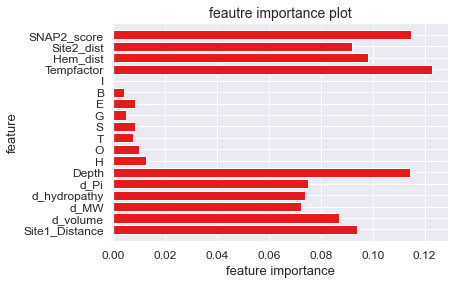

In [11]:
plot_feature_importances(forest_no_params)

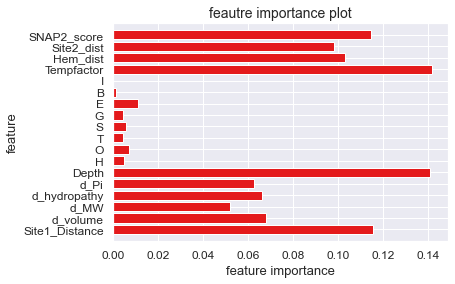

In [12]:
plot_feature_importances(forest_best_params)

5. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for AVERAGE PRECISION

In [13]:
#grid search with shuffled kfold validation
#use predict_proba function to calculate average_precision
kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(forest, param_grid, cv=kfold_shuffle, scoring='average_precision')
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set average precision: ', 
       average_precision_score(y_test_cv, grid_kfold_shuffle.predict_proba(X_test_cv)[:,1]), '\n')

grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=8, n_jobs=-1, random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.739152148416027
grid_kfold_shuffle test set average precision:  0.8465425643495117 



6. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for AREA UNDER ROC CURVE

In [14]:
#grid search with shuffled kfold validation
#use predict_prob a function ot calculate ROC AUC

kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(forest, param_grid, cv=kfold_shuffle, scoring='roc_auc')
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set AUC: ', 
       roc_auc_score(y_test_cv, grid_kfold_shuffle.predict_proba(X_test_cv)[:,1]), '\n')

grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=6, n_jobs=-1, random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.7319591434503716
grid_kfold_shuffle test set AUC:  0.8415458937198068 



7. Precision-recall curve with best preprocessing and parameters for PRECISION

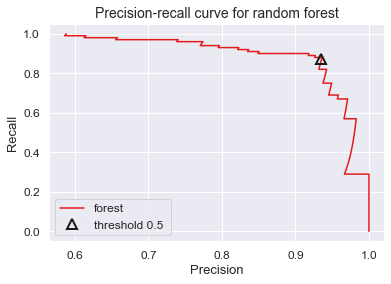

In [15]:
#precision recall curve for best average precision estimator
#max_depth=8

from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt

forest = RandomForestClassifier(max_depth=8, n_jobs=-1, random_state=0)
forest.fit(X_train_cv, y_train_cv)

precision, recall, thresholds = precision_recall_curve(y_test_nodup, forest.predict_proba(X_test_nodup)[:, 1])

plt.plot(precision, recall, label='forest')
close_default = np.argmin(np.abs(thresholds - 0.5))
plt.plot(precision[close_default], recall[close_default], '^', c='k', 
          markersize=10, label='threshold 0.5 ', fillstyle='none', mew=2)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-recall curve for random forest')
plt.legend(loc='best')
#plt.savefig('figures/PR_curve_RF.png')

8. ROC
curve with best preprocessing and parameters for AREA UNDER ROC CURVE

Text(0.5, 1.0, 'ROC curve for random forest')

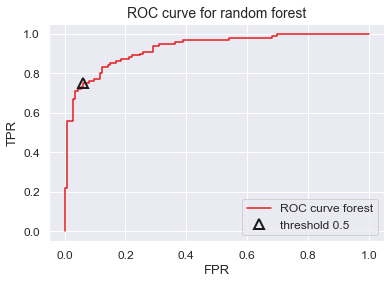

In [16]:
# parameters for best AUC: 
#max_depth = 6
from sklearn.metrics import roc_curve

forest = RandomForestClassifier(max_depth=6, n_jobs=-1, random_state=0)
forest.fit(X_train_cv, y_train_cv)

fpr, tpr, thresholds = roc_curve(y_test_nodup, forest.predict_proba(X_test_nodup)[:, 1])

plt.plot(fpr, tpr, label='ROC curve forest')
plt.xlabel('FPR')
plt.ylabel('TPR')
close_default = np.argmin(np.abs(thresholds - 0.5))
plt.plot(fpr[close_default], tpr[close_default], '^', markersize=10, label='threshold 0.5', 
         fillstyle='none', c='k', mew=2)
plt.legend(loc=4)
plt.title('ROC curve for random forest')
#plt.savefig('figures/ROC_curve_RF.png')

9. Use curves to determine if precision can be increased and FPR can be reduced 

- FPR could be shifted slightly with low cost to TPR

10. Produce confusion matrix with best parameters for precision or area under ROC curve (whichever gave best CV score)

In [17]:
#confusion matrix (max_depth=8)
#best parameters for average precision

from sklearn.metrics import confusion_matrix

forest = RandomForestClassifier(max_depth=8, n_jobs=-1, random_state=0)
forest.fit(X_train_cv, y_train_cv)
predict = forest.predict(X_test_nodup).astype(int)

#generate confusion matrix
confusion = confusion_matrix(y_test_nodup, predict)

#calculate precision, sensitivity, specficity, FPR, errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100
major_error = (confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100

print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

# begins creates list for model comparison:
direct_VME = very_major_error
direct_ME = major_error

Precision:  0.9347826086956522
Sensitivity:  0.86
Specificity:  0.9469026548672567
FPR : 0.053097345132743334
very major error : 5.3097345132743365
major error:  14.000000000000002

 confusion matrix: 
 [[107   6]
 [ 14  86]]


{0: 121, 1: 92}


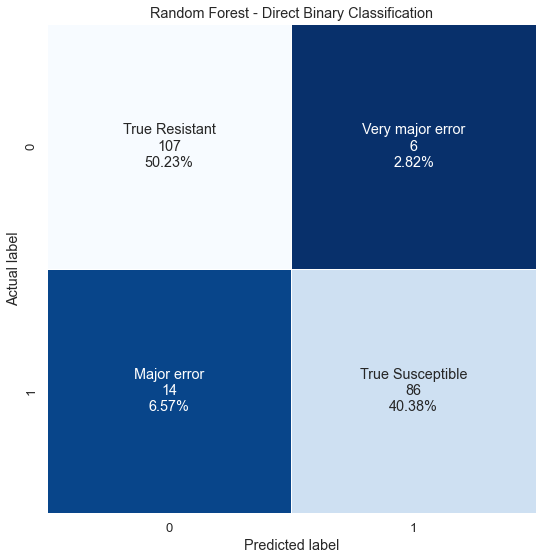

In [18]:
from sklearn import metrics
import seaborn as sns
unique, counts = np.unique(predict, return_counts=True)
print(dict(zip(unique, counts)))

cm = metrics.confusion_matrix(y_test_nodup, predict)
sns.set(font_scale=1.2)
plt.figure(figsize=(9,9))

group_names = ['True Resistant','Very major error','Major error','True Susceptible']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', linewidths=.5, square = True, cmap = 'Blues_r', cbar=False);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Random Forest - Direct Binary Classification');
#plt.savefig('figures/unshifted_direct_matrix_RF.png')

11. Shift decision threshold to improve precision and FPR - reducing instances where resistant cases are predicted to be susceptible

C:\Users\user\AppData\Local\Temp/ipykernel_31000/3942092046.py:28: RuntimeWarning: invalid value encountered in double_scalars
  grad_change = (m_error_cost / (-1*vm_error_cost))
C:\Users\user\AppData\Local\Temp/ipykernel_31000/3942092046.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  grad_change = (m_error_cost / (-1*vm_error_cost))
C:\Users\user\AppData\Local\Temp/ipykernel_31000/3942092046.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  grad_change = (m_error_cost / (-1*vm_error_cost))
C:\Users\user\AppData\Local\Temp/ipykernel_31000/3942092046.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  grad_change = (m_error_cost / (-1*vm_error_cost))


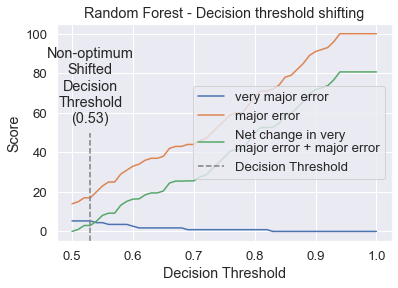

Optimum threshold to reduce very major error without     increasing major error by more than 1.5x :
 0.53


In [21]:
# graph showing how major and very major error changes with decision threshold

threshold  = np.linspace(0.5,1,num = 51)
very_major_error = []
major_error = []
net_error_change = []
threshold_shift = []

forest = RandomForestClassifier(max_depth=8, n_jobs=-1, random_state=0)
forest.fit(X_train_cv, y_train_cv)
predicted_proba = forest.predict_proba(X_test_nodup)

predict = (predicted_proba[:,1] >= 0.5).astype('int')
confusion = confusion_matrix(y_test_nodup, predict)
og_very_major_error = ((confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100)
og_major_error = ((confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100)

for i in threshold:
    predict = (predicted_proba[:,1] >= i).astype('int')
    confusion = confusion_matrix(y_test_nodup, predict)
    very_major_error.append((confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100)
    major_error.append((confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100)

    #code to mathematically determine optimum threshold shifting
    vm_error_cost = ((confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100) - og_very_major_error
    m_error_cost = ((confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100) - og_major_error
    net_error_change.append(m_error_cost + vm_error_cost)
    grad_change = (m_error_cost / (-1*vm_error_cost))
    if grad_change <= 1.5:
        threshold_shift.append(i)
    
    
    
plt.plot(threshold, very_major_error, label = 'very major error')
plt.plot(threshold, major_error, label = 'major error')
plt.plot(threshold, net_error_change, label = 'Net change in very\nmajor error + major error')
plt.axvline(x=0.53, ymax=0.5, color ='grey', label = 'Decision Threshold', linestyle ='--')
plt.text(0.53,55,'Non-optimum\nShifted\nDecision\nThreshold\n(0.53)', horizontalalignment = 'center')
plt.ylabel('Score')
plt.xlabel('Decision Threshold')
plt.legend(loc = 'right')
plt.title('Random Forest - Decision threshold shifting')
#plt.savefig('figures/decision_curve_RF.png')
plt.show()

if threshold_shift == []:
    optimum_thresh = 0.5
    print('Shifting does not improve results')
else:
    optimum_thresh = max(threshold_shift)
    print('Optimum threshold to reduce very major error without \
    increasing major error by more than 1.5x :\n'\
        ,max(threshold_shift))

In [22]:
# shift threshold accoriding to data above - optimum theshold to decrease FPR without
# increasing major error by more than 1.5 x
# = ~0.53


# NOTE - shift actually makes the model worse here, there is no change in FPR and a slight increase
# in major error

forest = RandomForestClassifier(max_depth=8, n_jobs=-1, random_state=0)
forest.fit(X_train_cv, y_train_cv)
predicted_proba = forest.predict_proba(X_test_nodup)
predict = (predicted_proba[:,1] >= optimum_thresh).astype('int')
confusion = confusion_matrix(y_test_nodup, predict)

Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100
major_error = (confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100

print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)

print ('\n confusion_matrix: \n', confusion)

# adds to list for model quality comparison
shifted_direct_VME = very_major_error
shifted_direct_ME = major_error

Precision:  0.9325842696629213
Sensitivity:  0.83
Specificity:  0.9469026548672567
FPR : 0.053097345132743334
very major error : 5.3097345132743365
major error:  17.0

 confusion_matrix: 
 [[107   6]
 [ 17  83]]


{0: 124, 1: 89}


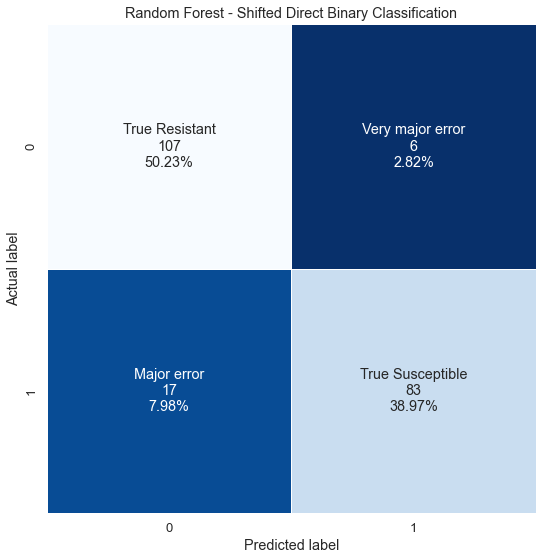

In [23]:
from sklearn import metrics
import seaborn as sns
unique, counts = np.unique(predict, return_counts=True)
print(dict(zip(unique, counts)))

cm = metrics.confusion_matrix(y_test_nodup, predict)

plt.figure(figsize=(9,9))

group_names = ['True Resistant','Very major error','Major error','True Susceptible']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', linewidths=.5, square = True, cmap = 'Blues_r', cbar=False);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Random Forest - Shifted Direct Binary Classification');
#plt.savefig('figures/shifted_direct_matrix_RF.png')

Optimum model: RandomForestClassifier(max_depth=8, n_jobs=-1, random_state=0)

Testing optimum model on a clinical test set (without duplicates removed)

In [24]:
forest = RandomForestClassifier(max_depth=8, n_jobs=-1, random_state=0)
forest.fit(X_train_cv, y_train_cv)
predict = forest.predict(X_test[:,1:]).astype(int)

#generate confusion matrix
confusion = confusion_matrix(y_test, predict)

#calculate precision, sensitivity, specficity, FPR, errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/len(y_test[y_test==0])*100)
major_error = (confusion[1][0]/len(y_test[y_test==1])*100)

print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

Precision:  0.9485294117647058
Sensitivity:  0.8716216216216216
Specificity:  0.9978560490045941
FPR : 0.0021439509954058744
very major error : 0.21439509954058195
major error:  12.837837837837837

 confusion matrix: 
 [[3258    7]
 [  19  129]]


{0: 3277, 1: 136}


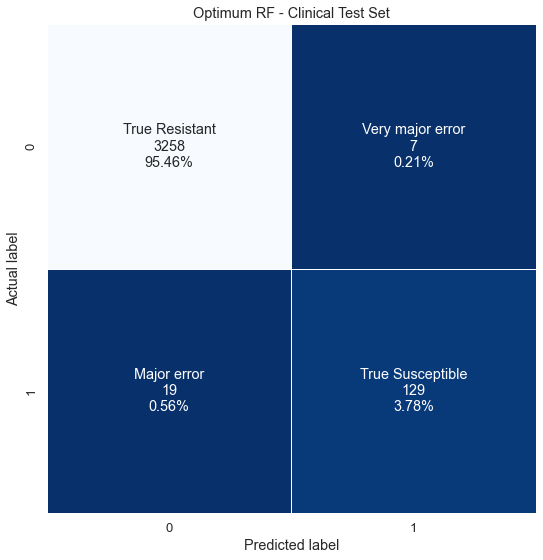

In [25]:
from sklearn import metrics

unique, counts = np.unique(predict, return_counts=True)
print(dict(zip(unique, counts)))

cm = metrics.confusion_matrix(y_test, predict)
plt.figure(figsize=(9,9))

group_names = ['True Resistant','Very major error','Major error','True Susceptible']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', linewidths=.5, square = True, cmap = 'Blues_r', cbar=False);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Optimum RF - Clinical Test Set');
#plt.savefig('figures/clinical_test_matrix_RF.png')

In [26]:
forest = RandomForestClassifier(max_depth=8, n_jobs=-1, random_state=0)
forest.fit(X_train_cv, y_train_cv)
predict = forest.predict(X_test[:,1:]).astype(int)

reverse_predict = []
for i in predict:
    if i == 0:
        reverse_predict.append(1)
    else:
        reverse_predict.append(0)
        
reverse_y_test = []
for i in y_test:
    if i == 0:
        reverse_y_test.append(1)
    else:
        reverse_y_test.append(0)
        
y_test_array = np.array(reverse_y_test)

#generate confusion matrix
confusion = confusion_matrix(reverse_y_test, reverse_predict)

#calculate precision, sensitivity, specficity, FPR, errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/len(y_test_array[y_test_array==0])*100)
major_error = (confusion[1][0]/len(y_test_array[y_test_array==1])*100)

print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

Precision:  0.9942020140372292
Sensitivity:  0.9978560490045941
Specificity:  0.8716216216216216
FPR : 0.1283783783783784
very major error : 12.837837837837837
major error:  0.21439509954058195

 confusion matrix: 
 [[ 129   19]
 [   7 3258]]


{0: 136, 1: 3277}


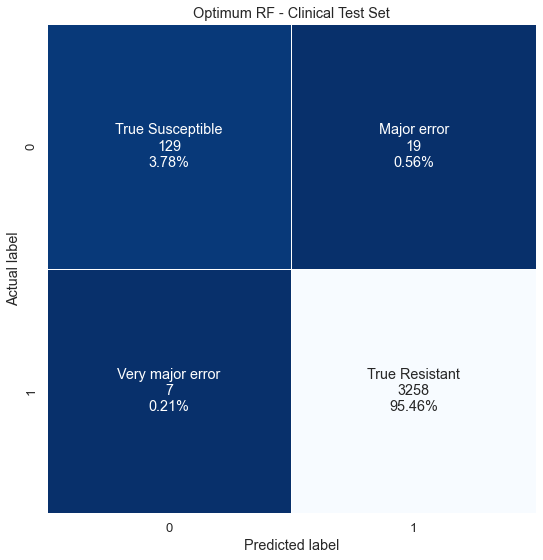

In [27]:
unique, counts = np.unique(reverse_predict, return_counts=True)
print(dict(zip(unique, counts)))

cm = metrics.confusion_matrix(reverse_y_test, reverse_predict)
plt.figure(figsize=(9,9))

group_names = ['True Susceptible','Major error','Very major error','True Resistant']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', linewidths=.5, square = True, cmap = 'Blues_r', cbar=False);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Optimum RF - Clinical Test Set');
#plt.savefig('figures/reverse_clinical_test_matrix_RF.png')

Feature importance data for model comparison:

Text(0.5, 1.0, 'Random Forest Feature Importance')

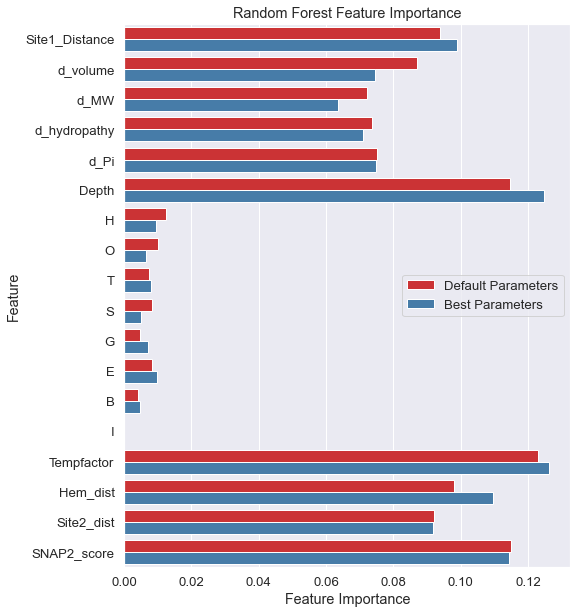

In [28]:
no_params = forest = RandomForestClassifier(n_jobs=-1, random_state=0)

best_params = RandomForestClassifier(max_depth=8, n_jobs=-1, random_state=0)

no_params.fit(X_train_cv, y_train_cv)
best_params.fit(X_train_cv, y_train_cv)

DF = pd.DataFrame({'Default Parameters':(no_params.feature_importances_),
                   'Best Parameters':(best_params.feature_importances_),
                   'n_features':np.arange(X_train_cv.shape[1])})
                          
df_melted = DF.melt("n_features",var_name="Params",value_name="importance")

sns.set_theme()
sns.set(rc={'figure.figsize':(8,10)})
sns.set(font_scale=1.2)
sns.set_palette(sns.color_palette('Set1'))
x = sns.barplot(data=df_melted, x='importance', y='n_features', hue='Params', orient='h')
plt.yticks(DF['n_features'], df.columns[3:])
x.set(xlabel='Feature Importance', ylabel='Feature')
plt.legend()
plt.title('Random Forest Feature Importance')
#plt.savefig('figures/direct_feature_coefficients_RF.png', bbox_inches='tight')

In [29]:
#produce relative importance df for best model for direct binary classification comparison
modal_df = abs(DF['Best Parameters'])
relative_importance = []
for i in modal_df:
    relative_importance.append(i / max(modal_df))
RF_df = pd.DataFrame({'RF_relative_importance':relative_importance,
                   'n_features':np.arange(X_train_cv.shape[1])})
RF_df.to_csv('RF_relative_importance.csv')

Indirect binary classification via multiclass MIC classification

1. Seperate the dataframe into a features and label dataset
2. Break datasets down into training and test sets containing only unique mutations
3. Establish pipeline and parameter grid for model and grid search
4. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for ACCURACY
5. Produce confusion matrix with best parameters for ACCURACY
6. Convert predicted MIC to binary phenotype
7. Produce binary confusion matrix with best parameters for ACCURACY

1. Seperate the dataframe into a features and label dataset

In [30]:
MIC_ML_data = ML_data.dropna(subset = ['METHOD_MIC'])

In [31]:
# need code to clean up values > 1.6 - need to see if RF can use continuous data

MIC_strings = []

for i in MIC_ML_data['METHOD_MIC']:
    if i == '3.2':
        MIC_strings.append('>1.6')
    elif i == '6.4':
        MIC_strings.append('>1.6')
    elif i == '12.8':
        MIC_strings.append('>1.6')
    elif i == '>12.8':
        MIC_strings.append('>1.6')
    else:
        MIC_strings.append(i)
        
MIC_ML_data['MIC_values'] = MIC_strings

C:\Users\user\AppData\Local\Temp/ipykernel_31000/380884722.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MIC_ML_data['MIC_values'] = MIC_strings


In [32]:
MIC_df = MIC_ML_data[['MIC_values','MUT_RESISTANCE','MUTATION','Site1_Distance','d_volume','d_MW',	\
              'd_hydropathy', 'd_Pi', 'Depth','H','O','T','S','G','E',  \
              'B','I','Tempfactor','Hem_dist','Site2_dist','SNAP2_score']]

# creates features numpy array
MIC_features = MIC_df[MIC_df.columns[2:]].to_numpy()

#creates resistance label column
MIC_label = MIC_df['MIC_values'].to_numpy()

2. Break datasets down into training and test sets containing only unique mutations

In [33]:
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(MIC_features, MIC_label,
                                                    random_state=0)

In [34]:
# creates features and label dfs from unique mutations when the original train-test split 
# is inputted 
def remove_duplicate_mutations(X_dataset, y_dataset):

    #converts long X_train and y_train to pd df to join
    X_train_df = pd.DataFrame(X_dataset)
    X_train_df.rename(columns = {0:'MUTATION'}, inplace = True)
    y_train_df = pd.DataFrame(y_dataset)
    y_train_df.rename(columns = {0:'MIC_VALUES'}, inplace = True)

    CV_train = X_train_df.join(y_train_df,  how = 'inner')

    #converts MIC_values to an integer so that the mean can be calculated for each mutation
    #with multiple samples
    MIC_integers = []

    for i in CV_train['MIC_VALUES']:
        if i == '<=0.025':
            MIC_integers.append(1)
        elif i == '0.05':
            MIC_integers.append(2)
        elif i == '0.1':
            MIC_integers.append(3)
        elif i == '0.2':
            MIC_integers.append(4)
        elif i == '0.4':
            MIC_integers.append(5)
        elif i == '0.8':
            MIC_integers.append(6)
        elif i == '1.6':
            MIC_integers.append(7)
        elif i == '>1.6':
            MIC_integers.append(8)
        
    CV_train['MIC_integers'] = MIC_integers

    #calculates the mean MIC value using the integer scale for each mutation
    MIC_calc_df = CV_train[['MUTATION','MIC_integers']].groupby('MUTATION').mean()
    
    #rounds the mean MIC value to the nearest integer for conversion back to the 
    #original MIC classes
    MIC_rounded = []
    for i in MIC_calc_df['MIC_integers']:
        rnd = round(i)
        MIC_rounded.append(rnd)
    MIC_calc_df['MIC_rounded'] = MIC_rounded
    
    #converts integers back to orignal MIC classes
    MIC_strings = []
    for i in MIC_calc_df['MIC_rounded']:
        if i == 1:
            MIC_strings.append('<=0.025')
        elif i == 2:
            MIC_strings.append('0.05')
        elif i == 3:
            MIC_strings.append('0.1')
        elif i == 4:
            MIC_strings.append('0.2')
        elif i == 5:
            MIC_strings.append('0.4')
        elif i == 6:
            MIC_strings.append('0.8')
        elif i == 7:
            MIC_strings.append('1.6')
        elif i == 8:
            MIC_strings.append('>1.6')   

    MIC_calc_df['MIC_final'] = MIC_strings

    # joins new MIC classes to CV_train df to replace the variation in MIC values associated
    # with mutations with multiple DST_measurements 
    MIC_calc_df.drop(['MIC_integers','MIC_rounded'], axis =1, inplace = True)
    CV_train.set_index('MUTATION', inplace = True)
    CV_train = CV_train.join(MIC_calc_df)
    CV_train.reset_index(inplace = True)
    CV_train.drop(['MIC_VALUES','MIC_integers'], axis = 1, inplace = True)
    CV_train.rename(columns = {'index':'MUTATION','MIC_final':'MIC_VALUES'}, inplace = True)
    
    #removes duplicates and mutation column
    CV_train_unique = CV_train.drop_duplicates(subset='MUTATION', keep = 'first')
    CV_train_unique.drop(['MUTATION'], axis = 1, inplace = True)

    #seperates into unique features and label numpy arrays
    features_unique = CV_train_unique[CV_train_unique.columns[:-1]].to_numpy()
    label_unique = CV_train_unique['MIC_VALUES']

    X_no_duplicates = (features_unique)
    y_no_duplicates = (label_unique)
    
    return (X_no_duplicates, y_no_duplicates)

In [35]:
X_train_nodup, y_train_nodup = remove_duplicate_mutations(X_train, y_train)
X_test_nodup, y_test_nodup = remove_duplicate_mutations(X_test, y_test)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [36]:
#split data into training and test sets
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_nodup, y_train_nodup,
                                                    random_state=0, test_size=0.2)

3. Establish pipeline and parameter grid for model and grid search

In [37]:
#no preprocessing - therefore, no pipeline
#build classifier and parameter grid

forest = RandomForestClassifier(n_jobs=-1, random_state=0)
param_grid = {'n_estimators':[10,20,30,40,50,60,100],
              'max_depth':[1,2,4,6,8,10], 'max_features': ['auto', 'sqrt'], \
             'min_samples_leaf': [1, 2, 4]}

4. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for ACCURACY

In [38]:
#Grid search with shuffled kfold cross validation
Kfold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold = GridSearchCV(forest, param_grid, cv=KFold_shuffle, n_jobs=-1)
grid_kfold.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test_cv, grid_kfold.predict(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=10, n_estimators=60, n_jobs=-1, random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.27439516129032254
grid_kfold_shuffle: test set average accuracy:  0.2 



In [39]:
#define and fit forests with best performing parameters, or default parameters
forest_best_params = RandomForestClassifier(max_depth=10, n_estimators=60, n_jobs=-1, random_state=0)
forest_no_params = RandomForestClassifier(random_state=0)
forest_best_params.fit(X_train_cv, y_train_cv)    
forest_no_params.fit(X_train_cv, y_train_cv)

#plot charts
def plot_feature_importances(model):
    n_features = features[:,1:].shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), df.columns[3:])
    plt.xlabel('feature importance')
    plt.ylabel('feature')
    plt.ylim(-1, n_features)
    plt.title('feautre importance plot')

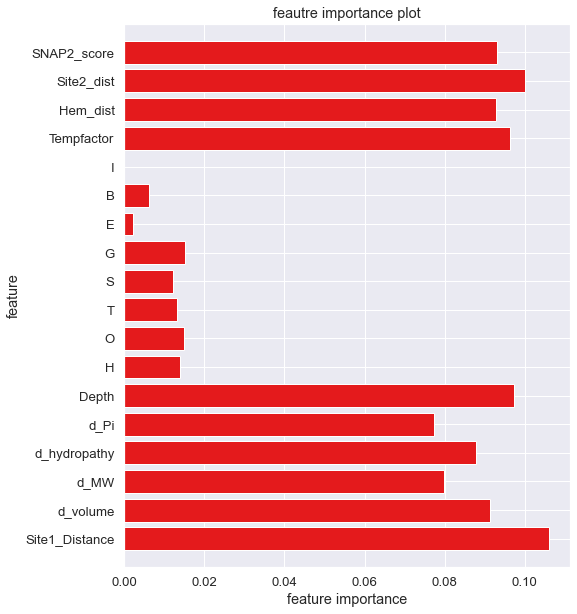

In [40]:
plot_feature_importances(forest_no_params)

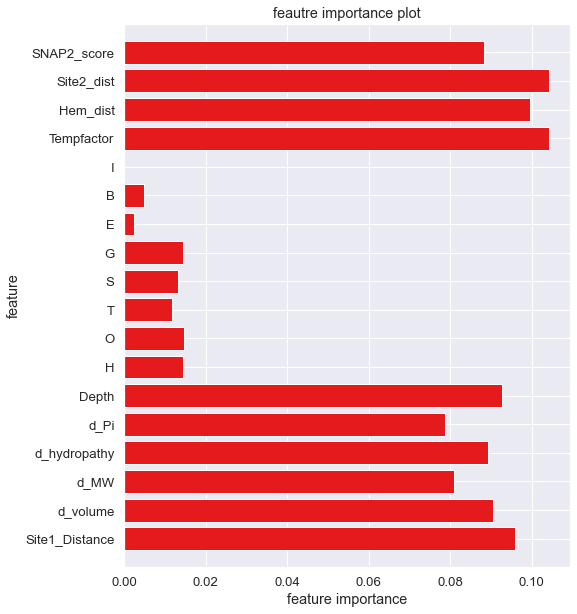

In [41]:
plot_feature_importances(forest_best_params)

5. Produce confusion matrix with best parameters for ACCURACY

In [42]:
#copy and fit classifier with best parameters from previous section
forest = forest_best_params
forest.fit(X_train_cv, y_train_cv)                 
                 
predict = forest.predict(X_test_nodup)
#generate confusion matrix
target_names = ['<=0.025','0.05','0.1','0.2','0.4','0.8',  '1.6','>1.6']
confusion = confusion_matrix(y_test_nodup, predict, labels = target_names)

print ('\n multiclass confusion matrix: \n', confusion)


 multiclass confusion matrix: 
 [[3 3 0 1 1 0 0 0]
 [6 2 0 1 0 0 0 0]
 [4 2 4 0 0 1 0 1]
 [2 3 1 2 2 1 1 1]
 [2 1 0 0 2 1 0 2]
 [1 0 1 1 0 3 1 1]
 [0 0 0 0 0 0 2 2]
 [0 2 0 1 1 0 2 7]]


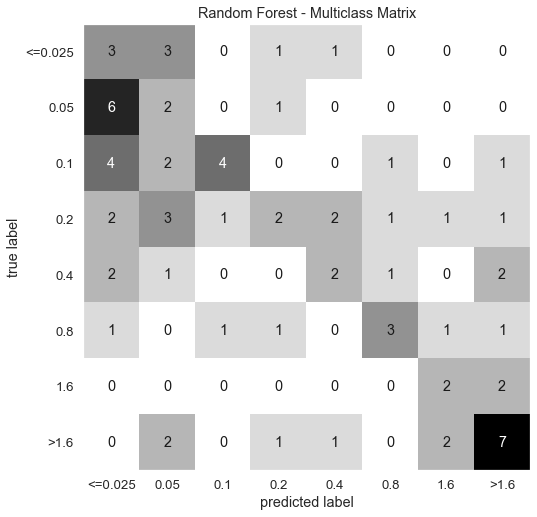

In [43]:
#generate heatmap of confusion matrix for visualisation
import mglearn

target_names = ['<=0.025','0.05','0.1','0.2','0.4','0.8',  '1.6','>1.6']
scores_image = mglearn.tools.heatmap(confusion, xlabel='predicted label',
                                     ylabel='true label', xticklabels=target_names,
                                     yticklabels=target_names, cmap=plt.cm.gray_r, fmt='%d')
plt.title('Random Forest - Multiclass Matrix')
plt.gca().invert_yaxis()
#plt.savefig('figures/indirect_multiclass_matrix_RF.png')

In [44]:
#generate classification report
from sklearn.metrics import classification_report

print (classification_report(y_test_nodup, predict, zero_division=True))

              precision    recall  f1-score   support

        0.05       0.15      0.22      0.18         9
         0.1       0.67      0.33      0.44        12
         0.2       0.33      0.15      0.21        13
         0.4       0.33      0.25      0.29         8
         0.8       0.50      0.38      0.43         8
         1.6       0.33      0.50      0.40         4
     <=0.025       0.17      0.38      0.23         8
        >1.6       0.50      0.54      0.52        13

    accuracy                           0.33        75
   macro avg       0.37      0.34      0.34        75
weighted avg       0.39      0.33      0.34        75



6. Convert predicted MIC to binary phenotype

In [45]:
# will categorise multiclass data into 2 groups
def MIC_to_binary(data):
    RS_dict = {0:['0.2','0.4','0.8','1.6','>1.6'],
           1:['<=0.025','0.05','0.1']}
    binary_list = []
    for i in data:
        for k,v in RS_dict.items():
            for j in v:
                if i == j:
                    binary_list.append(k)

    binary_array = np.array(binary_list)
    return binary_array

7. Produce binary confusion matrix with best parameters for ACCURACY

Precision:  0.6486486486486487
Sensitivity:  0.8275862068965517
Specificity:  0.717391304347826
FPR : 0.28260869565217395
very major error : 28.26086956521739
major error:  17.24137931034483

 confusion matrix: 
 [[33 13]
 [ 5 24]]


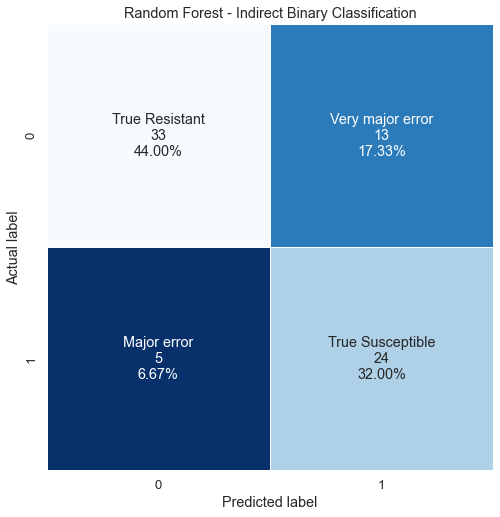

In [46]:
#generate confusion matrix
confusion = confusion_matrix(MIC_to_binary(y_test_nodup), MIC_to_binary(predict))
cm = metrics.confusion_matrix(MIC_to_binary(y_test_nodup), MIC_to_binary(predict))

#calculate precision, sensitivity, specificty, FPR, and errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/len(MIC_to_binary(y_test_nodup)[MIC_to_binary(y_test_nodup)==0]))*100
major_error = (confusion[1][0]/len(MIC_to_binary(y_test_nodup)[MIC_to_binary(y_test_nodup)==1]))*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

group_names = ['True Resistant','Very major error','Major error','True Susceptible']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', linewidths=.5, square = True, cmap = 'Blues_r', cbar=False);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Random Forest - Indirect Binary Classification');
#plt.savefig('figures/indirect_binary_matrix_RF.png')


#completes list of model quality values for model comparison
shifted_multiclass_VME = very_major_error
shifted_multiclass_ME = major_error

RF_quality = [direct_VME, direct_ME, shifted_direct_VME, shifted_direct_ME, \
              shifted_multiclass_VME,shifted_multiclass_ME]

RF_quality_df = pd.DataFrame({'RF_quality':RF_quality})
RF_quality_df.to_csv('RF_quality.csv')

In [47]:
print (classification_report(MIC_to_binary(y_test_nodup), MIC_to_binary(predict)))

              precision    recall  f1-score   support

           0       0.87      0.72      0.79        46
           1       0.65      0.83      0.73        29

    accuracy                           0.76        75
   macro avg       0.76      0.77      0.76        75
weighted avg       0.78      0.76      0.76        75

